In [1]:
import time
import numpy as np
from keras.datasets import cifar10
from keras.datasets import mnist
import matplotlib.pyplot as plt
#using tensorflow backend

Using TensorFlow backend.


In [2]:
#ok, verificado
#me pone el bias de manera correcta
#con el 1 al final
def reshapeimages(x,y):
    im_shape = x.shape[1:]
    x = np.reshape(x,(x.shape[0],np.prod(im_shape)))
    a = np.zeros((x.shape[0],np.prod(im_shape)+1))+1
    a[:,:-1] = x #le agrego los 1 al final de fila
    return a,y

In [3]:
#sampleo de data para los batch
def createbatch(x,y,batchsize):
    indices = np.random.choice(x.shape[0], batchsize, replace=False) #toma batchsize de filas random
    x_batch = x[indices] #selecciono en x y obtengo el batch
    y_batch = y[indices] #selecciono en y obtengo el batch
    return x_batch,y_batch

In [151]:
class LinearClassifier:
    #constructor, solo digo que tengo W
    def __init__(self):
        self.W = None
    #inicializo la matriz de pesos randomly (bias considerado, tambien random)
    def randominicializar(self,k,d):
        self.W = np.random.rand(d,k) #en un rango [0,1) 
        self.W = self.W*1e-3 #elementos chicos
    #calcula los scores
    def calculate_scores(self,x):
        return x.dot(self.W)
    #paso una imagenes y me da la categoria con mayor score para cada una
    def predict(self,x):
        a = self.calculate_scores(x)
        ypr = np.argmax(a,axis=1)
        return ypr
    #funcion de la practica, definida despues para cada linear classifier
    def loss_gradient(self,x,y):
        pass
    #funcion de costo, idem comentario que la anterior
    def loss_fun(self,x,y):
        pass
    #funcion accuracy para ver como piden en el enunciado
    def accuracy(self,x,y):
        ypr = self.predict(x)
        accper =  np.mean(ypr==y) 
        return accper
    #fit igual para SVM y softmax, como hablamos el miercoles con las epocas
    def fit(self,x,y,x_test,y_test,batchsize,alpha):
        epocas = 200
        vloss = []
        vacc = []
        for ie in range(epocas):
            print(ie)
            x,y = createbatch(x,y,x.shape[0])
            nit = int(x.shape[0]/batchsize)
            for it in range(nit):
                x_batch = x[it*batchsize:(it+1)*batchsize,:]
                y_batch = y[it*batchsize:(it+1)*batchsize]
                grad = self.loss_gradient(x_batch,y_batch)
                self.W -= (alpha)*(grad)
            vloss.append(self.loss_fun(x_test,y_test))
            vacc.append(self.accuracy(x_test,y_test))
        return vloss,vacc

In [152]:
class SVM(LinearClassifier):
    #data loss para una imagen en particular
    def __init__(self,lam,delta=1):
        super().__init__() #herencia
        self.delta = delta
        self.lam = lam
    #calculo el gradiente
    #(nota personal: version modificada, la anterior del gradiente andaba lenta por el for)
    def loss_gradient(self,x,y):
        #calculo la loss
        s = x.dot(self.W)
        sy = s[np.arange(x.shape[0]), y]
        margen = s-sy[:,np.newaxis]+self.delta
        margen = np.maximum(0,margen)
        margen[np.arange(x.shape[0]),y] = 0       
        #calculo el gradiente
        margen[margen>0]=1
        #clases que no dan ok, donde va la suma de las que le ganan a la correcta
        aux = margen.sum(axis=1)
        margen[np.arange(x.shape[0]),y] = -aux
        grad = (x.T).dot(margen) #como estaba en las slides
        grad = grad/(x.shape[0])
        grad = grad + 2*(self.W)*(self.lam)
        return grad
    #defino la loss function para SVM
    def loss_fun(self,x,y):
        s = x.dot(self.W)
        sy = s[np.arange(x.shape[0]), y]
        margen = s-sy[:,np.newaxis]+self.delta
        margen = np.maximum(0,margen)
        margen[np.arange(x.shape[0]),y] = 0       
        loss = margen.sum(axis=1)
        loss = sum(loss)/(x.shape[0])
        regu = self.lam*(sum((self.W**2).flatten()))
        loss = loss + regu
        return loss

In [5]:
class SoftMax(LinearClassifier):
    def __init__(self,lam):
        super().__init__() #herencia
        self.lam = lam
    #defino loss gradient para SoftMax
    def loss_gradient(self,x,y):
        s = x.dot(self.W)
        sm = s.max(axis=1)
        #teniendo en cuenta la estabilidad numerica
        s = s - sm[:,np.newaxis] #ref:notas de stanford cs231n, se hace esto para estabilidad numerica
        sy = s[np.arange(x.shape[0]),y]
        s = np.exp(s)
        aux = s.sum(axis=1)
        #calculo gradiente 
        grad = (1/aux)[:,np.newaxis]*s
        grad[np.arange(y.shape[0]),y] = grad[np.arange(y.shape[0]),y] - 1
        grad = ((x.T).dot(grad))/(x.shape[0])
        W2 = (self.W*self.W).flatten()
        grad = grad + 2*(self.lam)*(self.W)
        return grad
    #defino loss function para SoftMax
    def loss_fun(self,x,y):
        #primero calculamos el data loss
        s = x.dot(self.W)
        sm = s.max(axis=1)
        #teniendo en cuenta la estabilidad numerica
        s = s - sm[:,np.newaxis] #ref:notas de stanford cs231n, se hace esto para estabilidad numerica
        sy = s[np.arange(x.shape[0]),y]
        exp = np.exp(s)
        aux = exp.sum(axis=1)
        loss = np.log(aux) - sy
        loss = loss.mean()
        regu = self.lam*(sum((self.W**2).flatten()))
        loss = loss + (self.lam)*(regu)
        return loss

# softmax funciona ok

In [138]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data() #x = images #y = categories #loading data
x_train,y_train = reshapeimages(x_train,y_train)
x_test,y_test = reshapeimages(x_test,y_test)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [139]:
k=10 #10 categories
d=x_train.shape[1] #dimension del problema
lam = 1e-3 #lambda de la reg
alpha = 1e-7 #alpha del step
s = SoftMax(lam)
s.randominicializar(k,d)
start_time = time.time()
vloss, vacc = s.fit(x_train,y_train,x_test,y_test,100,alpha) #100 es batch size, los que eran 2**algo daban nit no entero
end_time = time.time()
print(end_time - start_time)

0
1
2
3
4
5
6


KeyboardInterrupt: 

In [ ]:
epochs = range(200)
plt.plot(epochs,vacc)

# probando el svm a ver que onda

In [159]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data() #x = images #y = categories #loading data
x_train,y_train = reshapeimages(x_train,y_train)
x_test,y_test = reshapeimages(x_test,y_test)
x_train = x_train - np.mean(x_train,axis=0)
x_test = x_test - np.mean(x_train,axis=0)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [160]:
k=10 #10 categories
d=x_train.shape[1] #dimension del problema
lam = 1e-3 #lambda de la reg
alpha = 1e-7 #alpha del step
s = SVM(lam)
s.randominicializar(k,d)
start_time = time.time()
vloss, vacc = s.fit(x_train,y_train,x_test,y_test,100,alpha) #100 es batch size, los que eran 2**algo daban nit no entero
end_time = time.time()
print(end_time - start_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
207.7924554347992


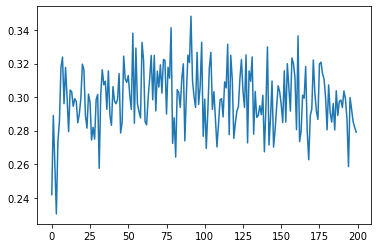

In [161]:
epochs = range(200)
plt.plot(epochs,vacc)